# Assignment 2: Convolution and Canny edge detection

## Exercise 2.1
Implement the convolution operation for 2-D images (i.e. no colors here, sorry). 

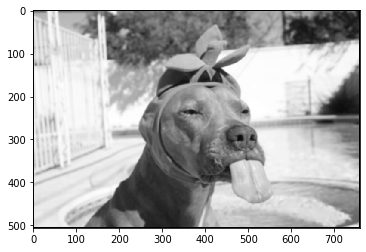

In [36]:
#%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from skimage import io, color


def conv2d(image, kernel):
    kernel_height, kernel_width = kernel.shape
    assert kernel_width % 2 != 0 and kernel_height % 2 != 0, 'kernel dimensions must but odd'
    kernel_sum = np.sum(np.fabs(kernel))
#     print(kernel, kernel_sum)

    image_height, image_width = image.shape
#     convoluted_image = np.zeros((image_height - kernel_height + 1, image_width - kernel_width + 1))
    convoluted_image = np.zeros(image.shape)
    
    padding_x = kernel_width // 2
    padding_y = kernel_height // 2
    
    for row in range(padding_y, image_height - padding_y):
        for col in range(padding_x, image_width - padding_x):
            area = image[row-padding_y:row+padding_y+1, col-padding_x:col+padding_x+1]
            # TODO: normalize?
            convoluted_image[row, col] = (area * kernel).sum() / kernel_sum
    
    return convoluted_image


image = color.rgb2gray(io.imread('images/dog.jpg'))
# print(image.shape)
# print(image)

kernel = np.array([
    [2,  4,  5,  4, 2],
    [4,  9, 12,  9, 4],
    [5, 12, 15, 12, 5],
    [4,  9, 12,  9, 4],
    [2,  4,  5,  4, 2],
])

plt.imshow(conv2d(image, kernel), cmap='gray')


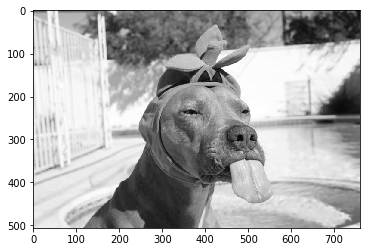

In [30]:
plt.imshow(image, cmap='gray')

Convolve an image of your choice with a Gaussian kernel. Play around with the size of the kernel and the standard deviation of the Gaussian. Show your results (***RESULT***). 

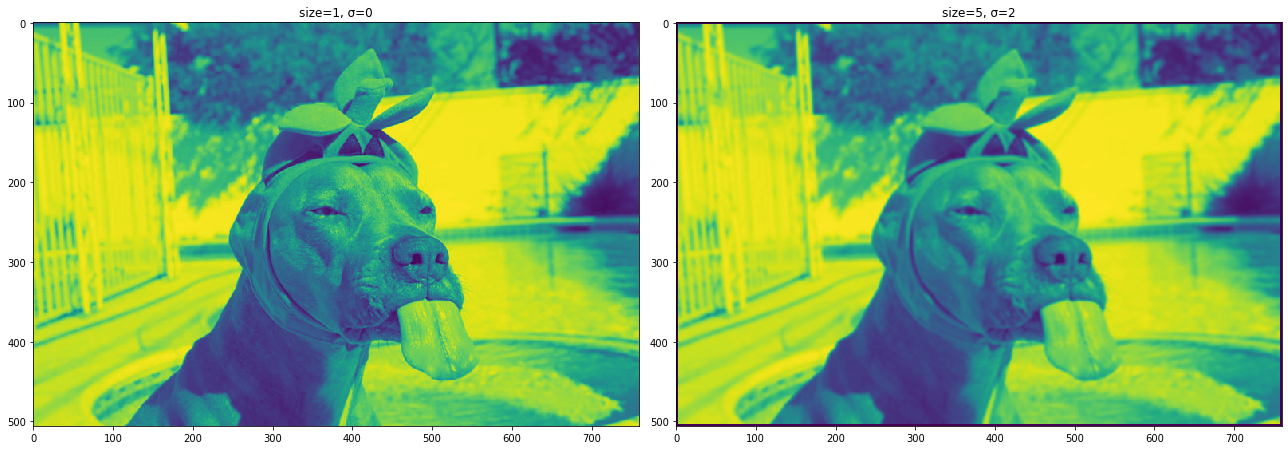

In [31]:
import numpy as np
from scipy import signal


def gaussian_kernel(size, standard_deviation):
    """Returns a 2D Gaussian kernel array."""
    gkern1d = signal.gaussian(size, std=standard_deviation).reshape(size, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d


kernels = (
    # No-op for comparison.
    dict(size=1, standard_deviation=0),
    # Actually blurring kernels.
    dict(size=5, standard_deviation=2),
#     dict(size=15, standard_deviation=2),
#     dict(size=5, standard_deviation=7),
#     dict(size=15, standard_deviation=7),
#     dict(size=25, standard_deviation=2),
#     dict(size=25, standard_deviation=7),
#     dict(size=25, standard_deviation=15),
)



convoluted_images = [
    conv2d(image, gaussian_kernel(**kernel))
    for kernel in kernels
]

fig = io.imshow_collection(convoluted_images)
fig.set_figheight(18)
fig.set_figwidth(18)
fig.tight_layout()
for i, ax in enumerate(fig.axes):
    try:
        kernel = kernels[i]
        ax.set_title(f'size={kernel["size"]}, σ={kernel["standard_deviation"]}')
    except IndexError:
        pass


Now, implement a simple edge detector by first filtering with a Sobel operator and then thresholding the ***RESULT***. How does smoothing the input change the ***RESULT***?

## Exercise 1.2 Canny Edge Detection

### Preprocessing
If you haven't yet: smooth the image with a Gaussian of your choice. Then use the Sobel operator to create the gradient magnitude and direction matrices (see slides page 23). Round the gradient directions to the 8-neighbor's directions. Display all  intermediate ***RESULT***s!


[[-1 -1 -1]
 [ 0  0  0]
 [ 1  1  1]]


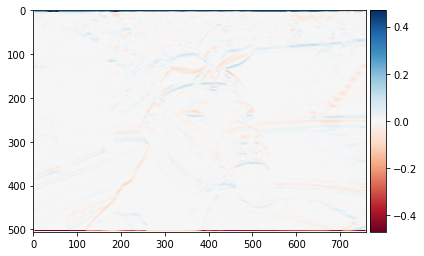

In [41]:
smoothed = conv2d(image, gaussian_kernel(size=7, standard_deviation=3))

# io.imshow(smoothed)

sobel_x = np.array([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1],
])
sobel_y = sobel_x.T
# print(sobel_y)

edges_vertical = conv2d(smoothed, sobel_x)
edges_horizontal = conv2d(smoothed, sobel_y)
# io.imshow(edges_vertical)
io.imshow(edges_horizontal)


### Non-Maximum Suppression
Implement the Non-Maximum Suppression step as described in the lecture. Subtract the result from the gradient magnitude image and show the ***RESULT***!

### Thresholding and Edge Tracing
Implement the edge tracing as described in the lecture and show the final result for three different threshold pairs: two low thresholds (e.g. 20 and 50), high thresholds (e.g. 80 and 120) and thresholds with large spacing (e.g. 40 and 140). (***RESULT***)
